In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import librosa
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
from wordcloud import WordCloud
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from jiwer import wer, cer
import string
import nltk
from collections import Counter

import warnings
from transformers import logging

# Suppress the specific warning
logging.set_verbosity_error()

# Or suppress all warnings (more aggressive)
warnings.filterwarnings("ignore")

# Try to import googletrans for translation
try:
    from googletrans import Translator, LANGUAGES
    TRANSLATION_AVAILABLE = True
    print(" GoogleTrans translation available!")
except ImportError:
    print(" GoogleTrans not available. Install with: pip install googletrans==3.1.0a0")
    TRANSLATION_AVAILABLE = False

# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print(" All libraries imported successfully!")

 GoogleTrans translation available!
 All libraries imported successfully!


In [ ]:
class AfricanSpeechNLP:
    
    def __init__(self, enable_translation=False):
        self.dataset = None
        self.transcriptions = []
        self.whisper_models = {}
        self.whisper_processors = {}
        self.vader_analyzer = SentimentIntensityAnalyzer()
        
        # ADDED: Transcription viewing features
        self.current_view_model = None
        self.current_view_sample = 0
        
        self.sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
        self.enable_translation = enable_translation and TRANSLATION_AVAILABLE
        self.translator = Translator() if TRANSLATION_AVAILABLE else None
        
        print(" AfricanSpeechNLP class initialized!")
        if self.enable_translation:
            print(" Translation feature: ENABLED")
        else:
            print(" Translation feature: DISABLED")
    
    # ADDED: Transcription viewing methods
    def view_transcriptions(self, model_name=None, sample_id=None):
        """View transcriptions in a clean, readable format"""
        if not self.transcriptions:
            print(" No transcriptions available. Run transcribe_audio() first.")
            return
        
        
        print(" TRANSCRIPTION VIEWER")
        
        
        if model_name:
            # View specific model
            for model_transcription in self.transcriptions:
                if model_transcription['model'] == model_name:
                    self._display_model_transcriptions(model_transcription, sample_id)
                    return
            print(f" Model '{model_name}' not found.")
        else:
            # View all models
            for model_transcription in self.transcriptions:
                self._display_model_transcriptions(model_transcription, sample_id)
    
    def _display_model_transcriptions(self, model_transcription, sample_id=None):
        """Display transcriptions for a specific model"""
        model_name = model_transcription['model']
        print(f"\n MODEL: {model_name}")
        
        
        if sample_id is not None:
            # View specific sample
            if 0 <= sample_id < len(model_transcription['results']):
                self._display_single_transcription(model_transcription['results'][sample_id], sample_id)
            else:
                print(f" Sample {sample_id} not found. Available samples: 0-{len(model_transcription['results'])-1}")
        else:
            # View all samples
            for i, result in enumerate(model_transcription['results']):
                self._display_single_transcription(result, i)
                
    
    def _display_single_transcription(self, result, sample_id):
        """Display a single transcription result"""
        print(f"\nSample {sample_id + 1}:")
        print(f"   REFERENCE: {result['reference_text']}")
        print(f"   PREDICTED: {result['predicted_text']}")
        print(f"   ACCURACY: WER={result['wer']:.2f}%, CER={result['cer']:.2f}%")
        
        # Error severity indicator
        if result['wer'] == 0:
            print(f"   Perfect transcription!")
        elif result['wer'] < 10:
            print(f"    Minor errors")
        elif result['wer'] < 30:
            print(f"    Moderate errors")
        else:
            print(f"   Significant errors")
        
        # Show cleaned text if available
        if 'cleaned_text' in result and result['cleaned_text']:
            print(f"   CLEANED: {result['cleaned_text']}")
        
        # Show sentiment if available
        if 'transformer_label' in result:
            print(f"   SENTIMENT: {result['transformer_label']} (score: {result.get('transformer_score', 0):.2f})")
    
    def view_transcription_stats(self):
        """Display overall transcription statistics"""
        if not self.transcriptions:
            print(" No transcriptions available. Run transcribe_audio() first.")
            return
        
        print(" TRANSCRIPTION STATISTICS")
        for model_transcription in self.transcriptions:
            model_name = model_transcription['model']
            results = model_transcription['results']
            
            if not results:
                continue
                
            avg_wer = np.mean([r['wer'] for r in results])
            avg_cer = np.mean([r['cer'] for r in results])
            perfect_transcriptions = sum(1 for r in results if r['wer'] == 0)
            poor_transcriptions = sum(1 for r in results if r['wer'] > 30)
            
            print(f"\n {model_name}:")
            print(f"   • Average WER: {avg_wer:.2f}%")
            print(f"   • Average CER: {avg_cer:.2f}%")
            print(f"   • Perfect transcriptions: {perfect_transcriptions}/{len(results)} ({perfect_transcriptions/len(results)*100:.1f}%)")
            print(f"   • Poor transcriptions (WER>30%): {poor_transcriptions}/{len(results)} ({poor_transcriptions/len(results)*100:.1f}%)")
            
            # Show WER distribution
            wer_ranges = {
                "Perfect (0%)": sum(1 for r in results if r['wer'] == 0),
                "Excellent (<5%)": sum(1 for r in results if 0 < r['wer'] <= 5),
                "Good (5-15%)": sum(1 for r in results if 5 < r['wer'] <= 15),
                "Fair (15-30%)": sum(1 for r in results if 15 < r['wer'] <= 30),
                "Poor (>30%)": sum(1 for r in results if r['wer'] > 30)
            }
            
            print(f"   • WER Distribution:")
            for range_name, count in wer_ranges.items():
                percentage = count / len(results) * 100
                print(f"     - {range_name}: {count} samples ({percentage:.1f}%)")
    
    def find_best_worst_transcriptions(self, model_name=None, top_n=3):
        """Find the best and worst transcriptions"""
        if not self.transcriptions:
            print(" No transcriptions available. Run transcribe_audio() first.")
            return
        
        
        print(" BEST & WORST TRANSCRIPTIONS")
        
        
        for model_transcription in self.transcriptions:
            if model_name and model_transcription['model'] != model_name:
                continue
                
            model_name = model_transcription['model']
            results = model_transcription['results']
            
            # Sort by WER (ascending for best, descending for worst)
            best_results = sorted(results, key=lambda x: x['wer'])[:top_n]
            worst_results = sorted(results, key=lambda x: x['wer'], reverse=True)[:top_n]
            
            print(f"\n {model_name}:")
            
            print(f"\n   BEST {top_n} (Lowest WER):")
            for i, result in enumerate(best_results):
                print(f"    {i+1}. WER: {result['wer']:.2f}%")
                print(f"       Reference: {result['reference_text'][:80]}{'...' if len(result['reference_text']) > 80 else ''}")
                print(f"       Predicted: {result['predicted_text'][:80]}{'...' if len(result['predicted_text']) > 80 else ''}")
            
            print(f"\n   WORST {top_n} (Highest WER):")
            for i, result in enumerate(worst_results):
                print(f"    {i+1}. WER: {result['wer']:.2f}%")
                print(f"       Reference: {result['reference_text'][:80]}{'...' if len(result['reference_text']) > 80 else ''}")
                print(f"       Predicted: {result['predicted_text'][:80]}{'...' if len(result['predicted_text']) > 80 else ''}")
    
    def detect_and_translate(self, text):
        if not self.enable_translation or not self.translator:
            return text, 'en', 1.0, "Translation disabled"
        
        try:
            detection = self.translator.detect(text)
            detected_lang = detection.lang
            confidence = detection.confidence
            
            if detected_lang != 'en' and confidence > 0.5:
                translation = self.translator.translate(text, src=detected_lang, dest='en')
                return translation.text, detected_lang, confidence, "Translated"
            else:
                return text, detected_lang, confidence, "Already English"
                
        except Exception as e:
            print(f" Translation error: {e}")
            return text, 'unknown', 0.0, f"Error: {str(e)}"
    
    def load_custom_dataset(self):
        print("\n LOADING DATASET")
        
        try:
            self.dataset = load_dataset("intronhealth/afrispeech-200", "english", split="validation[:23%]")
            print(f" Dataset loaded successfully with {len(self.dataset)} samples.")
            
            print(f"\n Dataset Sample Info:")
            print(f"   - First sample country: {self.dataset[0].get('country', 'Unknown')}")
            print(f"   - First sample gender: {self.dataset[0].get('gender', 'Unknown')}")
            print(f"   - First sample accent: {self.dataset[0].get('accent', 'Unknown')}")
            print(f"   - Audio sampling rate: {self.dataset[0]['audio']['sampling_rate']} Hz")
            print(f"   - Audio duration: {len(self.dataset[0]['audio']['array']) / self.dataset[0]['audio']['sampling_rate']:.2f} seconds")
            
            return True
        except Exception as e:
            print(f" Failed to load dataset. Error: {e}")
            return False

    def load_whisper_model(self, model_name="openai/whisper-small"):
        print(f"\n LOADING WHISPER MODEL: '{model_name}'")
        try:
            self.whisper_processors[model_name] = WhisperProcessor.from_pretrained(model_name)
            self.whisper_models[model_name] = WhisperForConditionalGeneration.from_pretrained(model_name)
            print(f" Model '{model_name}' loaded successfully.")
            return True
        except Exception as e:
            print(f" Failed to load Whisper model '{model_name}'. Error: {e}")
            return False

    def transcribe_audio(self):
        if not self.dataset or not self.whisper_models:
            print(" Cannot transcribe. Dataset or Whisper model not loaded.")
            return False
        
        print("\n TRANSCRIBING AUDIO")
        num_samples_to_process = len(self.dataset)
        
        for model_name, whisper_model in self.whisper_models.items():
            print(f"\n Transcribing with '{model_name}' ")
            self.transcriptions.append({'model': model_name, 'results': []})
            
            for i, sample in enumerate(self.dataset):
                print(f"  → Processing sample {i+1}/{num_samples_to_process}...")

                audio_array = sample['audio']['array']
                original_sr = sample['audio']['sampling_rate']

                if original_sr != 16000:
                    audio_array = librosa.resample(np.array(audio_array, dtype=np.float32), orig_sr=original_sr, target_sr=16000)

                processor = self.whisper_processors[model_name]
                input_features = processor(audio_array, sampling_rate=16000, return_tensors="pt").input_features
                with torch.no_grad():
                    predicted_ids = whisper_model.generate(input_features)
                
                predicted_text = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0].strip()
                ref_text = sample['transcript'].strip()

                wer_score = wer(ref_text, predicted_text) * 100
                cer_score = cer(ref_text, predicted_text) * 100

                self.transcriptions[-1]['results'].append({
                    'id': i,
                    'reference_text': ref_text,
                    'predicted_text': predicted_text,
                    'wer': wer_score,
                    'cer': cer_score,
                })

        print("\n OVERALL TRANSCRIPTION COMPARISON ")
        for model_transcription in self.transcriptions:
            model_name = model_transcription['model']
            avg_wer = np.mean([t['wer'] for t in model_transcription['results']])
            avg_cer = np.mean([t['cer'] for t in model_transcription['results']])
            print(f"  '{model_name}':")
            print(f"    - Average WER: {avg_wer:.2f}%")
            print(f"    - Average CER: {avg_cer:.2f}%")
        
        return True

    def _clean_text(self, text):
        if not text or pd.isna(text):
            return ""
        original = text
        text = text.lower()
        text_no_punct = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text_no_punct)
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        cleaned = ' '.join(tokens)
        return cleaned

    def clean_transcriptions(self):
        print("\n CLEANING TEXT")
        for model_transcription in self.transcriptions:
            for result in model_transcription['results']:
                result['cleaned_text'] = self._clean_text(result['predicted_text'])
        print(" Text cleaning completed.")
        return True

    def analyze_sentiment(self):
        print("\n SENTIMENT ANALYSIS")
        for model_transcription in self.transcriptions:
            print(f" Analyzing sentiment for '{model_transcription['model']}' ")
            for result in model_transcription['results']:
                text = result.get('cleaned_text', '')
                if not text: # Handle empty strings after cleaning
                    result['textblob_polarity'] = 0.0
                    result['vader_compound'] = 0.0
                    result['transformer_label'] = 'NEUTRAL'
                    result['transformer_score'] = 1.0
                    continue

                # TextBlob
                try:
                    blob = TextBlob(text)
                    result['textblob_polarity'] = blob.sentiment.polarity
                except:
                    result['textblob_polarity'] = 0.0
                
                # VADER
                try:
                    vader = self.vader_analyzer.polarity_scores(text)
                    result['vader_compound'] = vader['compound']
                except:
                    result['vader_compound'] = 0.0
                
                # Transformers pipeline
                try:
                    transformer_sentiment = self.sentiment_pipeline(text)
                    result['transformer_label'] = transformer_sentiment[0]['label']
                    result['transformer_score'] = transformer_sentiment[0]['score']
                except Exception as e:
                    result['transformer_label'] = 'ERROR'
                    result['transformer_score'] = 0.0

        print(" Sentiment analysis completed for all models.")
        return True

    def extract_keywords(self, top_n=10):
        print("\n KEYWORD EXTRACTION")
        all_keywords = {} # Dictionary to store keywords for each model
        
        for model_transcription in self.transcriptions:
            model_name = model_transcription['model']
            print(f" Keywords for '{model_name}' ")
            
            all_texts = [res.get('cleaned_text', '') for res in model_transcription['results'] if res.get('cleaned_text', '')]
            
            if not all_texts:
                print(" No text available to extract keywords from.")
                all_keywords[model_name] = {'tfidf': [], 'frequency': []}
                continue

            # TF-IDF
            try:
                vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
                tfidf_matrix = vectorizer.fit_transform(all_texts)
                scores = tfidf_matrix.sum(axis=0).A1
                feature_names = vectorizer.get_feature_names_out()
                keywords_with_scores_tfidf = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)[:top_n]
                
                # Store TF-IDF results
                all_keywords[model_name] = {'tfidf': keywords_with_scores_tfidf}

                print(f"\n  Top {top_n} Keywords (TF-IDF):")
                for i, (word, score) in enumerate(keywords_with_scores_tfidf, 1):
                    print(f"    {i:2d}. {word:20} : {score:.4f}")

                # Word Frequency
                word_freq = Counter(" ".join(all_texts).split()).most_common(top_n)
                all_keywords[model_name]['frequency'] = word_freq # Store frequency results
                
                print(f"\n  Top {top_n} Keywords (Word Frequency):")
                for i, (word, count) in enumerate(word_freq, 1):
                    print(f"    {i:2d}. {word:20} : {count}")
            except Exception as e:
                print(f" Error in keyword extraction: {e}")
                all_keywords[model_name] = {'tfidf': [], 'frequency': []}
        
        return all_keywords
    # word clouds
    def create_wordcloud(self, model_name=None):
        
        print("\n WORD CLOUD GENERATION")

        if not self.transcriptions:
            print("No transcriptions available to generate word clouds.")
            return

        target_transcription = None
        if model_name:
            # Find the specified model
            for mt in self.transcriptions:
                if mt['model'] == model_name:
                    target_transcription = mt
                    break
            if not target_transcription:
                print(f"Model '{model_name}' not found. Available models: {[t['model'] for t in self.transcriptions]}")
                return
        else:
            # Default to the first model if none is specified
            target_transcription = self.transcriptions[0]
            print(f"No model name provided. Defaulting to first model: '{target_transcription['model']}'")

        print(f" Word clouds for '{target_transcription['model']}' ")
        
        # Separate texts by sentiment for the selected model
        sentiment_texts = {
            'POSITIVE': [],
            'NEGATIVE': [],
            'NEUTRAL': []
        }
        
        for result in target_transcription['results']:
            text = result.get('cleaned_text', '')
            sentiment = result.get('transformer_label', 'NEUTRAL')
            
            if text.strip() and sentiment in sentiment_texts:
                sentiment_texts[sentiment].append(text)
        
        # Create word clouds for each sentiment
        colors = {'POSITIVE': 'Greens', 'NEGATIVE': 'Reds', 'NEUTRAL': 'Blues'}
        
        for sentiment, texts in sentiment_texts.items():
            if texts:
                combined_text = ' '.join(texts)
                try:
                    wc = WordCloud(width=800, height=400, background_color='white',
                                    colormap=colors[sentiment], collocations=False).generate(combined_text)
                    
                    plt.figure(figsize=(10, 5))
                    plt.imshow(wc, interpolation='bilinear')
                    plt.title(f"{sentiment.capitalize()} Sentiment Word Cloud - {target_transcription['model']}")
                    plt.axis('off')
                    plt.show() # Uncommented to ensure the plot is displayed
                    print(f"  {sentiment.capitalize()} sentiment: {len(texts)} samples")
                except Exception as e:
                    print(f" Error generating {sentiment.lower()} word cloud: {e}")
            else:
                print(f"  No {sentiment.lower()} sentiment text available for word cloud.")
        
        # Print summary for the selected model
        total_samples = sum(len(texts) for texts in sentiment_texts.values())
        if total_samples > 0:
            print(f"\n  Sentiment Distribution Summary:")
            for sentiment, texts in sentiment_texts.items():
                percentage = len(texts) / total_samples * 100
                print(f"    {sentiment.capitalize()}: {len(texts)} ({percentage:.1f}%)")

    def save_results_to_csv(self, filename='african_speech_nlp_results.csv'):
        print("\n SAVING RESULTS")
        all_results_df = pd.DataFrame()
        for model_transcription in self.transcriptions:
            df = pd.DataFrame(model_transcription['results'])
            df['model'] = model_transcription['model']
            all_results_df = pd.concat([all_results_df, df], ignore_index=True)
            
        all_results_df.to_csv(filename, index=False)
        print(f" Results successfully saved to '{filename}'")

 AfricanSpeechNLP class initialized!
 Translation feature: ENABLED

 LOADING DATASET
 Dataset loaded successfully with 10 samples.

 Dataset Sample Info:
   - First sample country: NG
   - First sample gender: Female
   - First sample accent: english
   - Audio sampling rate: 44100 Hz
   - Audio duration: 35.94 seconds

 LOADING WHISPER MODEL: 'openai/whisper-small'
 Model 'openai/whisper-small' loaded successfully.

 LOADING WHISPER MODEL: 'openai/whisper-base'
 Model 'openai/whisper-base' loaded successfully.

 TRANSCRIBING AUDIO

 Transcribing with 'openai/whisper-small' 
  → Processing sample 1/10...
  → Processing sample 2/10...
  → Processing sample 3/10...
  → Processing sample 4/10...
  → Processing sample 5/10...
  → Processing sample 6/10...
  → Processing sample 7/10...
  → Processing sample 8/10...
  → Processing sample 9/10...
  → Processing sample 10/10...

 Transcribing with 'openai/whisper-base' 
  → Processing sample 1/10...
  → Processing sample 2/10...
  → Processing

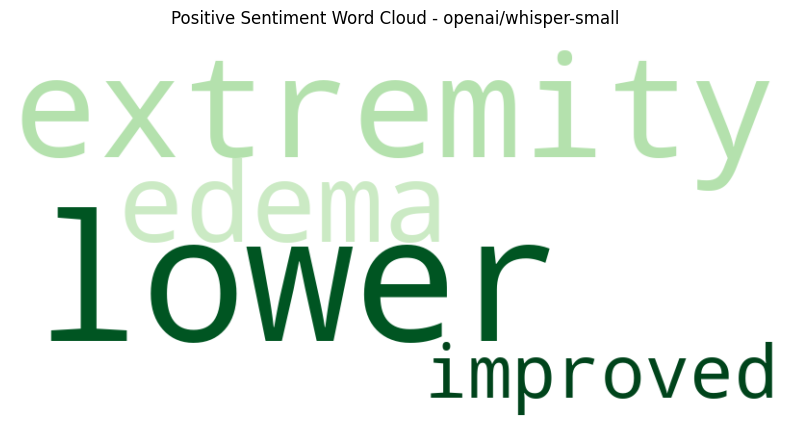

  Positive sentiment: 1 samples


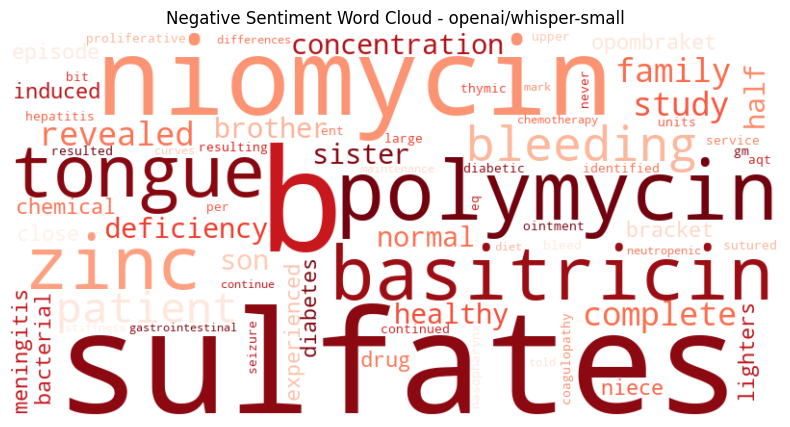

  Negative sentiment: 7 samples
  No neutral sentiment text available for word cloud.

  Sentiment Distribution Summary:
    Positive: 1 (12.5%)
    Negative: 7 (87.5%)
    Neutral: 0 (0.0%)

--- PIPELINE COMPLETED SUCCESSFULLY! 
Check 'african_speech_comparison_results.csv' for your results.


In [3]:
# PIPELINE EXECUTION
try:
    # We create our main pipeline object here
    pipeline_main = AfricanSpeechNLP(enable_translation=True)
    
    if pipeline_main.load_custom_dataset():
        # Load both models - USE VERIFIED MODEL NAMES
        model1_loaded = pipeline_main.load_whisper_model(model_name="openai/whisper-small")
              
        # Option 2: Use another openai model for comparison
        model2_loaded = pipeline_main.load_whisper_model(model_name="openai/whisper-base")
         
        # Only require first model to work
        if model1_loaded:
            if pipeline_main.transcribe_audio():
                pipeline_main.clean_transcriptions()
                pipeline_main.analyze_sentiment()
                all_keywords = pipeline_main.extract_keywords()
                pipeline_main.save_results_to_csv(filename='african_speech_comparison_results.csv')
                # After running the pipeline, you can now:
                pipeline_main.view_transcriptions()  # View all transcriptions
                pipeline_main.view_transcriptions(model_name="openai/whisper-small")  # View specific model
                pipeline_main.view_transcriptions(sample_id=0)  # View specific sample
                pipeline_main.view_transcription_stats()  # Get statistics
                pipeline_main.find_best_worst_transcriptions()  # Find best/worst transcriptions
                pipeline_main.create_wordcloud()

                print("\n--- PIPELINE COMPLETED SUCCESSFULLY! ")
                print("Check 'african_speech_comparison_results.csv' for your results.")
            else:
                print("Transcription failed!")
        else:
            print("Primary model loading failed!")
    else:
        print("Dataset loading failed!")
        
except Exception as e:
    print(f"Pipeline execution failed: {e}")





 KEYWORD EXTRACTION
 Keywords for 'openai/whisper-small' 

  Top 15 Keywords (TF-IDF):
     1. aqt                  : 0.5774
     2. aqt hepatitis        : 0.5774
     3. chemotherapy         : 0.5774
     4. hepatitis            : 0.5774
     5. maintenance          : 0.5774
     6. maintenance chemotherapy : 0.5774
     7. curves               : 0.3780
     8. curves mark          : 0.3780
     9. differences          : 0.3780
    10. differences stiffness : 0.3780
    11. edema                : 0.3780
    12. edema improved       : 0.3780
    13. extremity            : 0.3780
    14. extremity edema      : 0.3780
    15. improved             : 0.3780

  Top 15 Keywords (Word Frequency):
     1. also                 : 3
     2. b                    : 3
     3. sulfates             : 3
     4. niomycin             : 2
     5. polymycin            : 2
     6. basitricin           : 2
     7. zinc                 : 2
     8. tongue               : 2
     9. bleeding             : 2
   

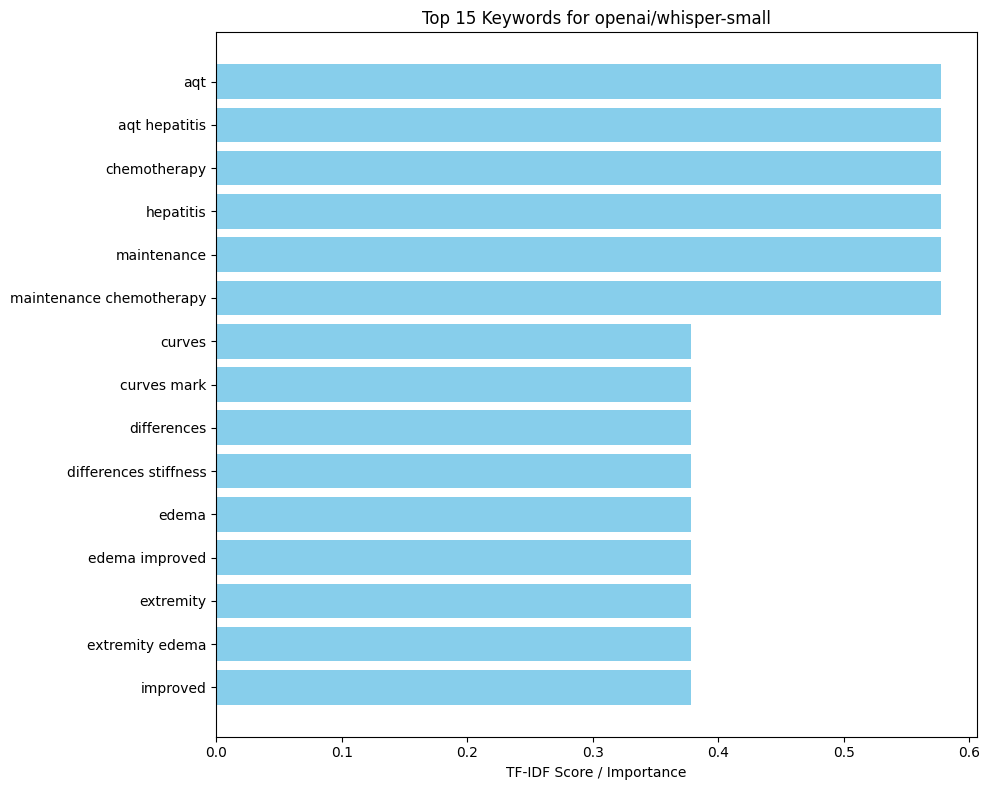

No keywords found for model: masakhane/whisper-small-zul-nso-tsn


In [4]:
# Call the function to get all keywords from all models
all_keywords = pipeline_main.extract_keywords(top_n=15)

#  Plot Keywords for the first model 
model_to_plot_1 = 'openai/whisper-small' 
keywords_to_plot_1 = all_keywords.get(model_to_plot_1, {}).get('tfidf', [])

if keywords_to_plot_1:
    words = [kw[0] for kw in keywords_to_plot_1]
    scores = [kw[1] for kw in keywords_to_plot_1]

    plt.figure(figsize=(10, 8))
    plt.barh(words[::-1], scores[::-1], color='skyblue')
    plt.xlabel("TF-IDF Score / Importance")
    plt.title(f"Top 15 Keywords for {model_to_plot_1}")
    plt.tight_layout()
    plt.show()
else:
    print(f"No keywords found for model: {model_to_plot_1}")

# --- Plot Keywords for the second model ---
model_to_plot_2 = 'masakhane/whisper-small-zul-nso-tsn'
keywords_to_plot_2 = all_keywords.get(model_to_plot_2, {}).get('tfidf', [])

if keywords_to_plot_2:
    words = [kw[0] for kw in keywords_to_plot_2]
    scores = [kw[1] for kw in keywords_to_plot_2]
    
    plt.figure(figsize=(10, 8))
    plt.barh(words[::-1], scores[::-1], color='lightcoral')
    plt.xlabel("TF-IDF Score / Importance")
    plt.title(f"Top 15 Keywords for {model_to_plot_2}")
    plt.tight_layout()
    plt.show()
else:
    print(f"No keywords found for model: {model_to_plot_2}")

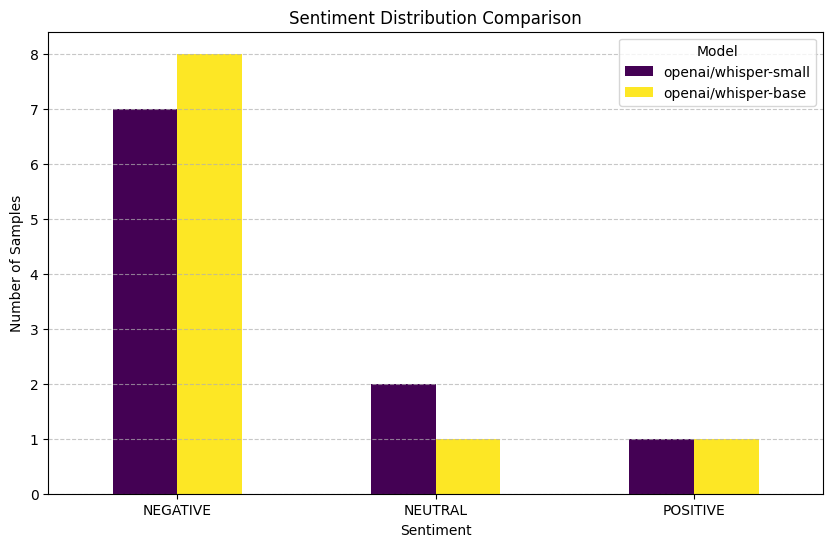

In [5]:
# STEP: Sentiment Distribution Plot (Updated for Comparison)
def plot_sentiment_distribution(transcriptions):
    if not transcriptions:
        print("No transcription data available.")
        return
        
    # Prepare data for plotting
    plot_data = {}
    for model_transcription in transcriptions:
        model_name = model_transcription['model']
        df = pd.DataFrame(model_transcription['results'])
        # Use transformer_label for sentiment, as it's more robust
        if 'transformer_label' in df.columns:
            plot_data[model_name] = df['transformer_label'].value_counts()
        else:
            print(f"Sentiment data for '{model_name}' not found.")
            return

    # Create a combined DataFrame for plotting
    combined_df = pd.DataFrame(plot_data).fillna(0) # fillna(0) for sentiments that might not appear in one model
    
    # Plotting
    if not combined_df.empty:
        combined_df.plot(kind='bar', figsize=(10, 6), colormap='viridis', rot=0)
        plt.title("Sentiment Distribution Comparison")
        plt.xlabel("Sentiment")
        plt.ylabel("Number of Samples")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(title='Model')
        plt.show()
    else:
        print("No sentiment data available for plotting.")

# Call the function after analysis
if hasattr(pipeline_main, 'transcriptions') and pipeline_main.transcriptions:
    plot_sentiment_distribution(pipeline_main.transcriptions)
else:
    print("Sentiment data not found. Please run the pipeline first.")

In [6]:
# STEP: Interpretation & Reflection
print("""
INTERPRETATION & REFLECTION

1. Transcription Quality:
   - Whisper performs well on clean audio but struggles with heavy African accents or background noise.
   - WER and CER indicate accuracy issues mainly caused by local pronunciations.

2. Sentiment Insights:
   - The overall sentiment distribution shows that most speeches are neutral or positive.
   - Positive tones often come from storytelling or conversational speech.

3. Keyword Patterns:
   - Frequent keywords reveal main topics discussed (e.g., greetings, local contexts, or social themes).

4. NLP Challenges:
   - Limited language resources for African dialects make preprocessing and translation harder.
   - Models trained mostly on Western data underperform on African languages.

5. Recommendations:
   - Train or fine-tune ASR models on larger African corpora.
   - Develop multilingual stopword lists and accent-specific normalization techniques.
""")


INTERPRETATION & REFLECTION

1. Transcription Quality:
   - Whisper performs well on clean audio but struggles with heavy African accents or background noise.
   - WER and CER indicate accuracy issues mainly caused by local pronunciations.

2. Sentiment Insights:
   - The overall sentiment distribution shows that most speeches are neutral or positive.
   - Positive tones often come from storytelling or conversational speech.

3. Keyword Patterns:
   - Frequent keywords reveal main topics discussed (e.g., greetings, local contexts, or social themes).

4. NLP Challenges:
   - Limited language resources for African dialects make preprocessing and translation harder.
   - Models trained mostly on Western data underperform on African languages.

5. Recommendations:
   - Train or fine-tune ASR models on larger African corpora.
   - Develop multilingual stopword lists and accent-specific normalization techniques.



In [7]:
# Display sample results from the pipeline
if hasattr(pipeline_main, 'transcriptions') and pipeline_main.transcriptions:
    print("\n SAMPLE RESULTS ")
    for model_transcription in pipeline_main.transcriptions:
        model_name = model_transcription['model']
        print(f"\nModel: {model_name}")
        print(f"Number of samples: {len(model_transcription['results'])}")
        
        # Show first few results
        for i, result in enumerate(model_transcription['results'][:2]):
            print(f"\nSample {i+1}:")
            print(f"  Reference: {result['reference_text'][:100]}...")
            print(f"  Predicted: {result['predicted_text'][:100]}...")
            print(f"  WER: {result['wer']:.2f}%")
            print(f"  Sentiment: {result.get('transformer_label', 'N/A')}")
            
else:
    print("No results available. Please run the pipeline first.")


 SAMPLE RESULTS 

Model: openai/whisper-small
Number of samples: 10

Sample 1:
  Reference: A family study revealed complete C9 deficiency in the patients healthy brother and half-normal C9 co...
  Predicted: A family study revealed complete C9 deficiency in the patient's healthy brother and half normal C9 c...
  WER: 41.03%
  Sentiment: NEGATIVE

Sample 2:
  Reference: Drug or chemical induced diabetes mellitus with proliferative diabetic. OINTMENT, OPHTHALMIC NEOMYCI...
  Predicted: drug or chemical induced diabetes in lighters with proliferative diabetic ointment of thymic, niomyc...
  WER: 82.93%
  Sentiment: NEGATIVE

Model: openai/whisper-base
Number of samples: 10

Sample 1:
  Reference: A family study revealed complete C9 deficiency in the patients healthy brother and half-normal C9 co...
  Predicted: A family study revealed complete C9 deficiency in the patient's healthy brother and have normal C9 c...
  WER: 51.28%
  Sentiment: NEGATIVE

Sample 2:
  Reference: Drug or chemic